# Writer Identification based on their Handwriting


In [1]:
#imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import os
import pathlib
import io
from collections import defaultdict
import cv2

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa

from tensorflow.python.ops import io_ops
from tensorflow.python.ops import image_ops

%load_ext tensorboard
import datetime, os


In [2]:
#check if gpu is available
gpus = tf.config.list_physical_devices('GPU')
if(len(gpus)==0):
    print("Running on CPU")
else:
    print("Running on GPU")  

Running on CPU


In [2]:
#Path to CVL dataset
CVL_PATH = "/mounts/layout/dkvart/data/CVL"
#Path to IAM dataset
IAM_PATH = "/mounts/layout/dkvart/data/IAM"

In [3]:
def display_rand_images(PATH, R=4, C=2, size=(10,10)):
    '''
    Given a path to a directory, randomly display the images residing there. 
    '''
    temp = 0
    MAX_SHOW = R * C
    
    #matplot figure configuration
    figure = plt.figure(figsize=(size))
    data_dir = pathlib.Path(PATH)
    
    #create a numpy array and shuffle
    filenames = np.array(list(data_dir.glob('*')))
    np.random.shuffle(filenames)
    
    for i, filename in enumerate(filenames[:MAX_SHOW], 1):
        handwriting_sample = mpimg.imread(filename)
        figure.add_subplot(R, C, i)
        plt.imshow(handwriting_sample, cmap="gray")
        plt.title(filename.stem)
    plt.show()

# CVL handwriting samples

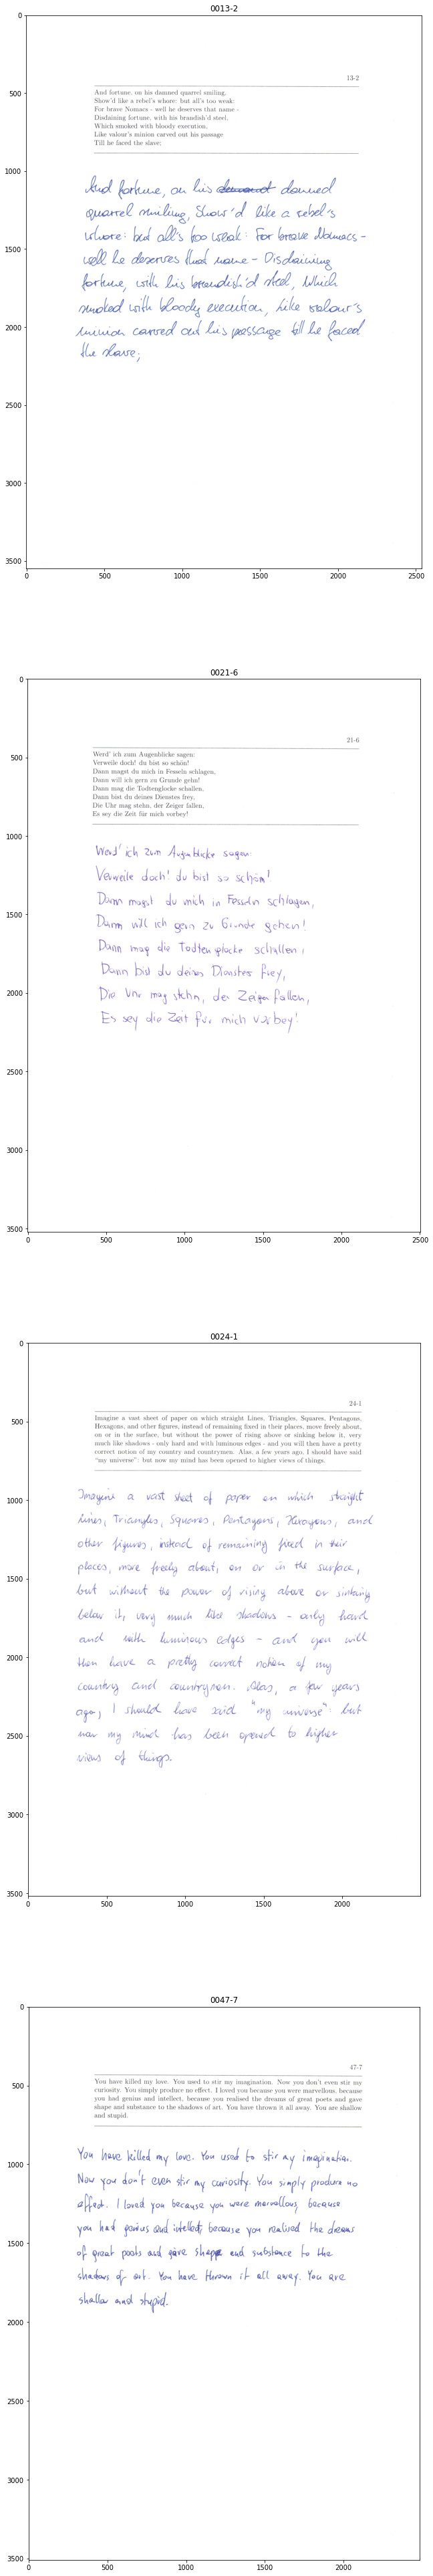

In [51]:
display_rand_images(CVL_PATH+"/trainset/pages/", R=4,C=1, size=(50,70))

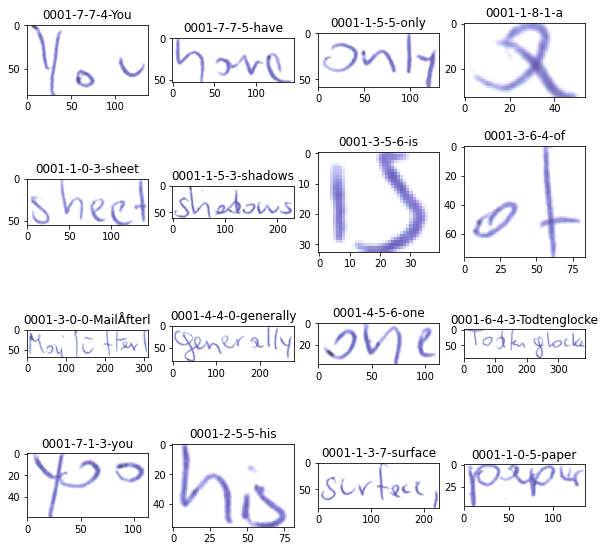

In [29]:
#Display the segmented words from writer with id:0001
display_rand_images(CVL_PATH+"/trainset/words/0001", R=4, C=4)

# IAM dataset
Showing only the segmented words

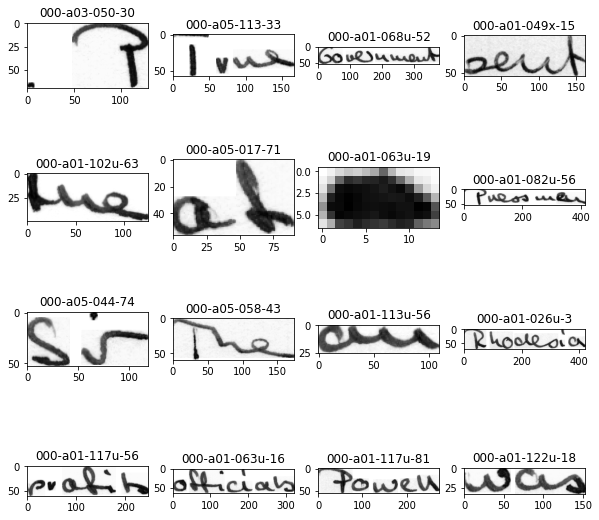

In [4]:
display_rand_images(IAM_PATH+'/words_reformatted/000', R=4, C=4)

# Data Augmentation 
Adopted from Tang and Wu 2016

LINE


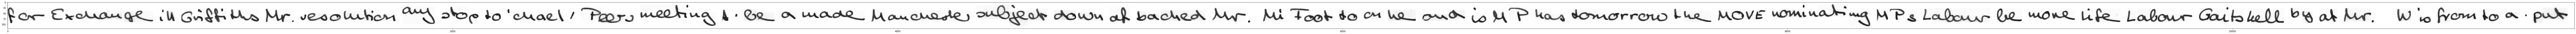

In [99]:
def sample_id(stem, data_source):
    '''
    Parses a filename to return a sample id
    '''
    if(data_source=="CVL"):
        return int(stem.split('-')[1])
    elif(data_source=="IAM"):
        tmp = stem.split('-')
        return tmp[1]+'-'+tmp[2]

def read_and_organize_filenames(PATH, data_source, file_extension='.tif'):#for CVL dataset
    '''
    Given a path to a directory that stores the images of words for a single writer, 
    reads all the images of words, and organizes them into a dictionary of arrays where each dict[sample_id]
    represents a collection of words for a single handwriting sample (Note that each writer has
    multiple handwriting samples)
    Argument: PATH -> to a directory that stores words written by a single writer
    '''
    directory = pathlib.Path(PATH)
    result_dict = defaultdict(list)
    
    for filename in directory.glob('*'+file_extension):
        s_id = sample_id(filename.stem, data_source)
        result_dict[s_id].append(filename)
        
    return result_dict
        

def equalize_height(HEIGHT, padding, img):
    '''
    Returns an image with a fixed height by padding with white pixels. 
    '''
    h = img.shape[0]
    w = img.shape[1]
    
    background = np.zeros((HEIGHT, w+padding), np.uint8)
    background += 255
    background[HEIGHT//2-h//2:HEIGHT//2+h//2, 0:w] = img[0:2*(h//2) ,:]
    return background

def produce_random_line(list_of_word_filenames):
    '''
    Given an array of filenames pointing to images of single words,
    randomly concatenates images of words horizontally.
    Returns a single image -> a line of handwriting
    '''
    PAD_SIZE = 30
    HEIGHT = 120
    list_of_word_filenames = np.array(list_of_word_filenames)
    np.random.shuffle(list_of_word_filenames)
    concatenated_image = np.zeros((HEIGHT,1), np.uint8)

    for filename in list_of_word_filenames:
        img = cv2.imread(str(filename), cv2.IMREAD_GRAYSCALE)
        if(img is None):
            print("Error reading the file:", filename)
            continue
        if(img.shape[0] < HEIGHT):
            padded_img = equalize_height(HEIGHT,PAD_SIZE, img)
            concatenated_image = cv2.hconcat([concatenated_image, padded_img])
    return concatenated_image

# dct = read_and_organize_filenames(CVL_PATH+'/trainset/words/0001', 'CVL')
# print(dct)
# image = produce_random_line(dct[1])
# plt.figure(figsize=(200,200))
# print("LINE")
# plt.imshow(image, cmap='gray')
# plt.show()

dct = read_and_organize_filenames(IAM_PATH+'/words_reformatted/000', 'IAM', '.png')
#example of a line
# print(dct['a01-000u'])
image = produce_random_line(dct['a01-000u'])
plt.figure(figsize=(200,200))
print("LINE")
plt.imshow(image, cmap='gray')
plt.show()


PAGE


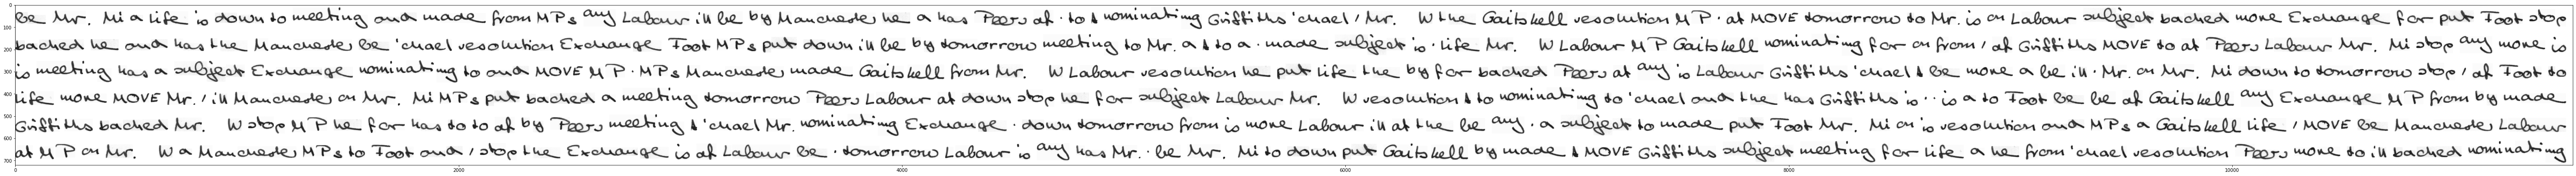

In [18]:
def produce_page(list_of_word_filenames, L):
    '''
    list_of_word_filenames --> a list of paths to the words that are coming from a single handwriting sample
    L --> number of lines to concatenate vertically
    This method calls produce_random_line to produce the lines from the same set of images of words
    and contatenates these lines vertically. 
    '''
    concatenated_image = produce_random_line(list_of_word_filenames)
    for i in range(L-1):
        next_line = produce_random_line(list_of_word_filenames)
        concatenated_image = cv2.vconcat([concatenated_image, next_line])
    return concatenated_image

#example of a page
# image = produce_page(dct[1], L=6)
image = produce_page(dct['a01-000u'], L=6)
plt.figure(figsize=(100,100))
print("PAGE")
plt.imshow(image, cmap='gray')
plt.show()

Below are some examples of patches


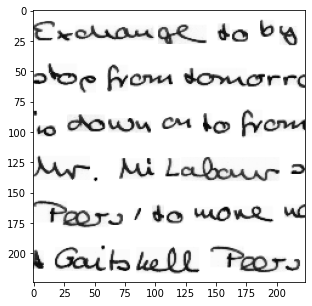

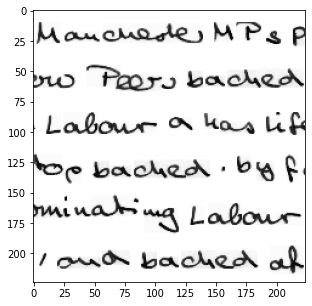

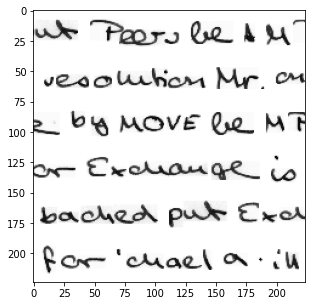

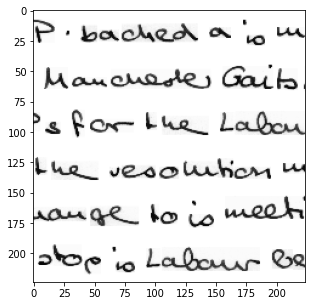

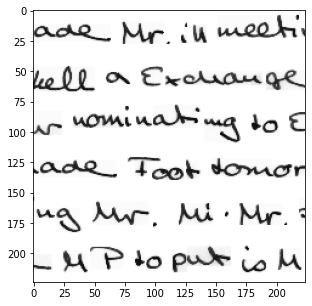

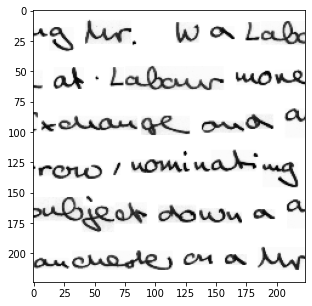

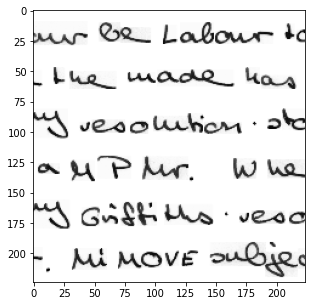

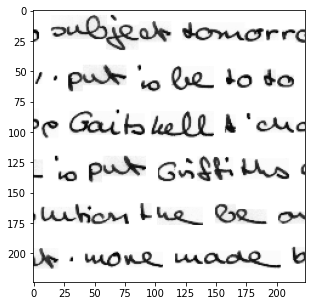

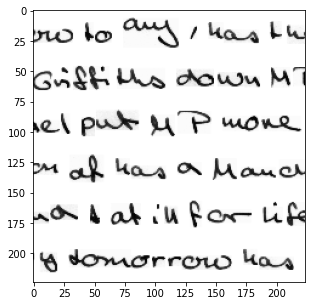

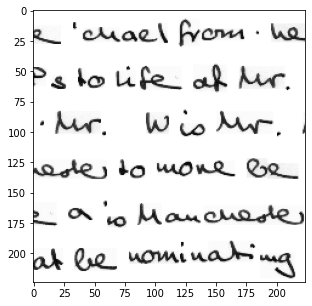

In [19]:
PATCH_DIM = 224
def produce_patches(paths_list, N):
    '''
    paths_list --> a list of paths to the words that are coming from a single document (obviously same writer)
    N --> number of pages to be constructed, from a single sample of handwriting.
    First, concatenates L=6 lines horizontally, then constructs N pages. 
    '''
    L = 6 #6 is a default value. usually, 15 words appear with L=6 in a single patch
    result = []
    
    for i in range(N):#number of different pages constructed. Note: page is not same as a patch
        page = produce_page(paths_list, L)

        h = page.shape[0]
        w = page.shape[1]
        
        #number of patches produced per page
        num_patches = w//h
        
        #produce square images of size h*h. Discard the remainder.
        for i in range(num_patches-1):
            next_patch = page[:,i*h:(i+1)*h]
            
            #resize all patches to 224x224. The original patch is already
            #a square image, so the aspect ratio doesn't change by resizing.
            next_patch = cv2.resize(next_patch, (PATCH_DIM, PATCH_DIM))
            result.append(next_patch)

    return result

#example of patches
res = produce_patches(dct['a01-000u'], N=2)

print("Below are some examples of patches")
for im in res[:10]:
    plt.figure(figsize=(5,5))
    plt.imshow(im, cmap='gray')
plt.show()

In [114]:
def augment_and_save(PATH, OUT_PATH, data_source, file_extension, N):
    '''
    PATH --> path to the a directory that is organized into writer classes, and each writer class directory
             contains images of handwritten words.
    OUT_PATH --> path where the patches will be saved.
    N --> number of pages constructed per sample. 
    Given the arguments above, this method goes through each handwriting sample, produces the patches for it, 
    and saves it to the disk.
    '''
    directory = pathlib.Path(PATH)

    total_patches_produced = 0
    #for each writer class
    for folder in directory.glob('*'):
        writer_id = folder.stem #writer id should be the name of the folder
        #a dictionary (associated with a single writer) of pairs:
        #                key - sample_id:
        #                value - the filenames for words coming from a single sample
        dct = read_and_organize_filenames(str(folder), data_source, file_extension)
        #make a directory /<writer_id> and place the generated patches inside.
        os.mkdir(OUT_PATH+'/'+writer_id)
        
        #for each sample
        for sample_id, paths_lst in dct.items():     
            
            #this patch_batch is associated with writer_id and sample_id
            patch_batch = produce_patches(paths_lst, N)
            
            total_patches_produced += len(patch_batch)
            
            #patch_counter is needed to differentiate between the patches generated from the same handwriting sample
            for patch_counter, patch in enumerate(patch_batch,1):
                out_filename = OUT_PATH+'/'+writer_id+'/'+writer_id+'-'+str(sample_id)+'-'+str(patch_counter)+'.jpg'
                blur = cv2.GaussianBlur(patch, (5,5), 0)
                thresh, otsu_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                cv2.imwrite(out_filename, otsu_img)
            print("Successfully saved", len(patch_batch),"patches for writer:", writer_id, "sample:", sample_id)
            break
            
    print("Num patches produced in total:", total_patches_produced)

In [101]:
#there were some empty files in the dataset. I'm ignoring them.
augment_and_save(IAM_PATH+'/words_reformatted', IAM_PATH+'/processed','IAM','.png', N=1)

Successfully saved 35 patches for writer: 135 sample: c01-014
Successfully saved 27 patches for writer: 135 sample: c01-009
Successfully saved 12 patches for writer: 307 sample: g02-073
Successfully saved 19 patches for writer: 551 sample: n06-163
Successfully saved 16 patches for writer: 551 sample: n06-186
Successfully saved 15 patches for writer: 551 sample: n06-156
Successfully saved 17 patches for writer: 551 sample: n06-148
Successfully saved 15 patches for writer: 551 sample: m06-019
Successfully saved 16 patches for writer: 551 sample: n06-169
Successfully saved 15 patches for writer: 551 sample: n06-182
Successfully saved 17 patches for writer: 551 sample: n06-194
Successfully saved 18 patches for writer: 551 sample: n06-175
Successfully saved 14 patches for writer: 551 sample: n06-201
Successfully saved 13 patches for writer: 338 sample: g06-047g
Successfully saved 11 patches for writer: 338 sample: g06-026g
Successfully saved 15 patches for writer: 338 sample: g06-050g
Succe

Successfully saved 28 patches for writer: 301 sample: g01-083
Successfully saved 13 patches for writer: 301 sample: h01-004
Successfully saved 16 patches for writer: 568 sample: n02-151
Successfully saved 12 patches for writer: 134 sample: b06-090
Successfully saved 15 patches for writer: 134 sample: b06-087
Successfully saved 12 patches for writer: 550 sample: n04-000
Successfully saved 12 patches for writer: 550 sample: m04-231
Successfully saved 13 patches for writer: 550 sample: n04-009
Successfully saved 12 patches for writer: 550 sample: m04-238
Successfully saved 14 patches for writer: 550 sample: m04-246
Successfully saved 21 patches for writer: 339 sample: g06-037h
Successfully saved 19 patches for writer: 339 sample: g06-011h
Successfully saved 14 patches for writer: 339 sample: g06-047h
Successfully saved 12 patches for writer: 339 sample: g06-026h
Successfully saved 16 patches for writer: 339 sample: g06-050h
Successfully saved 17 patches for writer: 339 sample: g06-031h
Su

Successfully saved 18 patches for writer: 084 sample: a06-119
Successfully saved 11 patches for writer: 242 sample: e04-114
Successfully saved 9 patches for writer: 242 sample: e04-109
Successfully saved 11 patches for writer: 242 sample: e04-103
Successfully saved 17 patches for writer: 070 sample: a06-025
Successfully saved 22 patches for writer: 414 sample: j04-111
Successfully saved 15 patches for writer: 414 sample: j04-115
Successfully saved 10 patches for writer: 626 sample: p03-142
Successfully saved 11 patches for writer: 477 sample: l03-004
Successfully saved 16 patches for writer: 645 sample: r02-070
Successfully saved 9 patches for writer: 221 sample: e02-021
Successfully saved 3 patches for writer: 013 sample: a01-058
Successfully saved 6 patches for writer: 013 sample: a01-063
Successfully saved 12 patches for writer: 013 sample: a01-053
Successfully saved 18 patches for writer: 483 sample: l04-062
Successfully saved 20 patches for writer: 483 sample: l04-052
Successfully

Successfully saved 16 patches for writer: 408 sample: j04-065
Successfully saved 11 patches for writer: 408 sample: j04-061
Successfully saved 12 patches for writer: 098 sample: b02-102
Successfully saved 12 patches for writer: 038 sample: a02-116
Successfully saved 10 patches for writer: 651 sample: r02-117
Successfully saved 17 patches for writer: 463 sample: l01-095
Successfully saved 19 patches for writer: 007 sample: a01-014
Successfully saved 20 patches for writer: 007 sample: a01-038
Successfully saved 18 patches for writer: 235 sample: e04-043
Successfully saved 19 patches for writer: 235 sample: e04-052
Successfully saved 20 patches for writer: 497 sample: l07-135
Successfully saved 14 patches for writer: 497 sample: l07-138
Successfully saved 14 patches for writer: 497 sample: l07-118
Successfully saved 17 patches for writer: 497 sample: l07-131
Successfully saved 6 patches for writer: 669 sample: r03-115
Successfully saved 17 patches for writer: 490 sample: l04-136
Successfu

Successfully saved 14 patches for writer: 635 sample: r06-022
Successfully saved 15 patches for writer: 635 sample: r06-027
Successfully saved 14 patches for writer: 635 sample: p06-242
Successfully saved 8 patches for writer: 635 sample: p06-248
Successfully saved 11 patches for writer: 635 sample: r06-011
Successfully saved 13 patches for writer: 635 sample: r06-018
Successfully saved 8 patches for writer: 635 sample: r06-143
Successfully saved 18 patches for writer: 251 sample: f01-066
Successfully saved 17 patches for writer: 063 sample: a04-081
Successfully saved 15 patches for writer: 063 sample: a04-089
Successfully saved 16 patches for writer: 063 sample: a04-085
Successfully saved 18 patches for writer: 097 sample: b02-097
Successfully saved 13 patches for writer: 090 sample: b01-053
Successfully saved 16 patches for writer: 090 sample: b01-049
Successfully saved 12 patches for writer: 090 sample: b01-044
Successfully saved 16 patches for writer: 064 sample: a04-096
Successful

Successfully saved 13 patches for writer: 384 sample: j06-005
Successfully saved 14 patches for writer: 384 sample: h06-085
Successfully saved 14 patches for writer: 384 sample: h06-082
Successfully saved 17 patches for writer: 384 sample: j06-008
Successfully saved 11 patches for writer: 384 sample: h06-092
Successfully saved 11 patches for writer: 384 sample: h06-079
Successfully saved 13 patches for writer: 519 sample: m01-160
Successfully saved 12 patches for writer: 189 sample: d04-050
Successfully saved 0 patches for writer: 129 sample: b06-027
Successfully saved 1 patches for writer: 129 sample: c06-014
Successfully saved 1 patches for writer: 129 sample: c06-103
Successfully saved 2 patches for writer: 129 sample: c06-138
Successfully saved 7 patches for writer: 572 sample: n03-064
Successfully saved 24 patches for writer: 116 sample: b05-032
Successfully saved 14 patches for writer: 324 sample: g04-060
Successfully saved 21 patches for writer: 324 sample: g04-063
Successfully 

Successfully saved 15 patches for writer: 126 sample: c06-087
Successfully saved 14 patches for writer: 126 sample: b06-110
Successfully saved 14 patches for writer: 126 sample: b06-036
Successfully saved 14 patches for writer: 314 sample: g03-043
Successfully saved 8 patches for writer: 110 sample: b04-089
Successfully saved 10 patches for writer: 110 sample: b04-096
Successfully saved 7 patches for writer: 110 sample: b04-081
Successfully saved 7 patches for writer: 110 sample: b04-103
Successfully saved 14 patches for writer: 322 sample: g04-052
Successfully saved 9 patches for writer: 574 sample: n03-079
Successfully saved 17 patches for writer: 580 sample: n03-120
Successfully saved 12 patches for writer: 128 sample: b06-071
Successfully saved 15 patches for writer: 128 sample: c06-027
Successfully saved 15 patches for writer: 128 sample: c06-076
Successfully saved 12 patches for writer: 128 sample: b06-019
Successfully saved 14 patches for writer: 128 sample: c06-128
Successfully

Successfully saved 14 patches for writer: 190 sample: d04-058
Successfully saved 14 patches for writer: 500 sample: m01-012
Successfully saved 17 patches for writer: 164 sample: c04-122
Successfully saved 15 patches for writer: 164 sample: c04-075
Successfully saved 24 patches for writer: 356 sample: h01-000
Successfully saved 22 patches for writer: 356 sample: h01-007
Successfully saved 11 patches for writer: 538 sample: m03-020
Successfully saved 16 patches for writer: 351 sample: g07-028a
Successfully saved 30 patches for writer: 351 sample: g07-018a
Successfully saved 20 patches for writer: 351 sample: g07-022a
Successfully saved 18 patches for writer: 351 sample: g07-014
Successfully saved 24 patches for writer: 351 sample: g07-026a
Successfully saved 16 patches for writer: 163 sample: c04-066
Successfully saved 13 patches for writer: 163 sample: c04-061
Successfully saved 14 patches for writer: 197 sample: d04-121
Successfully saved 16 patches for writer: 197 sample: d04-117
Succ

Successfully saved 22 patches for writer: 246 sample: e07-012
Successfully saved 17 patches for writer: 074 sample: a06-051
Successfully saved 12 patches for writer: 080 sample: a06-095
Successfully saved 19 patches for writer: 444 sample: k04-061
Successfully saved 17 patches for writer: 444 sample: k04-057
Successfully saved 23 patches for writer: 020 sample: a01-132
Successfully saved 17 patches for writer: 212 sample: e01-029
Successfully saved 22 patches for writer: 212 sample: e01-032
Successfully saved 15 patches for writer: 212 sample: e01-035
Successfully saved 24 patches for writer: 649 sample: r02-089
Successfully saved 19 patches for writer: 215 sample: e01-102
Successfully saved 16 patches for writer: 215 sample: e01-092
Successfully saved 17 patches for writer: 027 sample: a02-046
Successfully saved 14 patches for writer: 443 sample: k04-050
Successfully saved 22 patches for writer: 443 sample: k04-054
Successfully saved 20 patches for writer: 671 sample: r06-115
Successf

Successfully saved 19 patches for writer: 489 sample: l04-124
Successfully saved 19 patches for writer: 445 sample: k04-068
Successfully saved 12 patches for writer: 445 sample: k04-064
Successfully saved 14 patches for writer: 213 sample: e01-062
Successfully saved 12 patches for writer: 213 sample: e01-050
Successfully saved 13 patches for writer: 213 sample: e01-059
Successfully saved 18 patches for writer: 021 sample: a02-000
Successfully saved 16 patches for writer: 648 sample: r02-081
Successfully saved 13 patches for writer: 458 sample: l01-007
Successfully saved 16 patches for writer: 458 sample: l01-023
Successfully saved 14 patches for writer: 458 sample: l01-016
Successfully saved 17 patches for writer: 493 sample: l04-163
Successfully saved 14 patches for writer: 493 sample: l04-170
Successfully saved 13 patches for writer: 003 sample: a01-007x
Successfully saved 15 patches for writer: 003 sample: a01-003x
Successfully saved 14 patches for writer: 231 sample: e04-011
Succes

Successfully saved 14 patches for writer: 492 sample: l04-153
Successfully saved 14 patches for writer: 056 sample: a03-066
Successfully saved 16 patches for writer: 264 sample: f02-040
Successfully saved 10 patches for writer: 600 sample: p02-101
Successfully saved 11 patches for writer: 432 sample: k03-138
Successfully saved 18 patches for writer: 290 sample: f07-046b
Successfully saved 13 patches for writer: 069 sample: a06-020
Successfully saved 18 patches for writer: 297 sample: g01-025
Successfully saved 19 patches for writer: 297 sample: g01-022
Successfully saved 19 patches for writer: 297 sample: g01-027
Successfully saved 14 patches for writer: 435 sample: k03-157
Successfully saved 16 patches for writer: 607 sample: p02-135
Successfully saved 21 patches for writer: 263 sample: f02-038
Successfully saved 15 patches for writer: 051 sample: a03-040
Successfully saved 17 patches for writer: 638 sample: r02-006
Successfully saved 14 patches for writer: 093 sample: b01-118
Success

Successfully saved 19 patches for writer: 522 sample: m02-055
Successfully saved 16 patches for writer: 179 sample: d01-080
Successfully saved 15 patches for writer: 179 sample: d01-085
Successfully saved 21 patches for writer: 328 sample: g04-088
Successfully saved 19 patches for writer: 328 sample: g04-092
Successfully saved 17 patches for writer: 541 sample: m03-095
Successfully saved 9 patches for writer: 317 sample: g03-058
Successfully saved 14 patches for writer: 125 sample: b06-008
Successfully saved 13 patches for writer: 125 sample: b06-093
Successfully saved 12 patches for writer: 125 sample: c06-005
Successfully saved 10 patches for writer: 125 sample: c06-020
Successfully saved 12 patches for writer: 125 sample: b06-056
Successfully saved 14 patches for writer: 579 sample: n03-113
Successfully saved 10 patches for writer: 122 sample: b05-088
Successfully saved 13 patches for writer: 310 sample: g03-016
Successfully saved 15 patches for writer: 546 sample: m04-100
Successfu

In [115]:
augment_and_save(CVL_PATH+'/trainset/words', CVL_PATH+"/trainset/processed", 'CVL','.tif', N=1) 

Successfully saved 20 patches for writer: 0001 sample: 1
Successfully saved 11 patches for writer: 0001 sample: 2
Successfully saved 18 patches for writer: 0001 sample: 3
Successfully saved 10 patches for writer: 0001 sample: 4
Successfully saved 10 patches for writer: 0001 sample: 6
Successfully saved 15 patches for writer: 0001 sample: 7
Successfully saved 17 patches for writer: 0001 sample: 8
Successfully saved 20 patches for writer: 0002 sample: 1
Successfully saved 11 patches for writer: 0002 sample: 2
Successfully saved 17 patches for writer: 0002 sample: 3
Successfully saved 9 patches for writer: 0002 sample: 4
Successfully saved 9 patches for writer: 0002 sample: 6
Successfully saved 13 patches for writer: 0002 sample: 7
Successfully saved 14 patches for writer: 0002 sample: 8
Successfully saved 20 patches for writer: 0003 sample: 1
Successfully saved 12 patches for writer: 0003 sample: 2
Successfully saved 20 patches for writer: 0003 sample: 3
Successfully saved 12 patches for

Successfully saved 14 patches for writer: 0027 sample: 4
Successfully saved 20 patches for writer: 0027 sample: 8
Successfully saved 18 patches for writer: 0027 sample: 7
Successfully saved 16 patches for writer: 0028 sample: 1
Successfully saved 9 patches for writer: 0028 sample: 2
Successfully saved 14 patches for writer: 0028 sample: 3
Successfully saved 9 patches for writer: 0028 sample: 4
Successfully saved 9 patches for writer: 0028 sample: 6
Successfully saved 12 patches for writer: 0028 sample: 7
Successfully saved 13 patches for writer: 0028 sample: 8
Successfully saved 18 patches for writer: 0029 sample: 1
Successfully saved 11 patches for writer: 0029 sample: 2
Successfully saved 12 patches for writer: 0029 sample: 3
Successfully saved 10 patches for writer: 0029 sample: 4
Successfully saved 10 patches for writer: 0029 sample: 6
Successfully saved 14 patches for writer: 0029 sample: 7
Successfully saved 14 patches for writer: 0029 sample: 8
Successfully saved 18 patches for 

In [107]:
#same preprocessing steps need to be applied to the testset
#but in this case we can just let N=1, because we're not trying to augment this data.
augment_and_save(CVL_PATH+'/testset/words', CVL_PATH+"/testset/processed", N=1) 

TypeError: augment_and_save() missing 2 required positional arguments: 'data_source' and 'file_extension'

At this point, I'm manually splitting the training data into training and validation sets. Note that in order to get the useful information from the validation loss, I need the classes in the training and validation data sets to be disjoint. The reason for this is that the test set is also disjoint (in terms of writers) from the training set. The number of writer classes in the (original) training set is just 27 :( I'm setting aside 4 writer classes for validation.

# CNN trained with triplet loss

I am using IAM dataset for training.
CVL's default trainset as a validation set.
CVL's default testset as a test set.

In [116]:
exp='exp4'

training_data_dir = pathlib.Path(IAM_PATH+"/processed")
validation_data_dir = pathlib.Path(CVL_PATH+"/trainset/processed")

image = mpimg.imread(next(training_data_dir.glob('000/*')))
img_height, img_width = image.shape
print("Patch WIDTH:", img_width)
print("Patch HEIGHT:", img_height)

Patch WIDTH: 224
Patch HEIGHT: 224


Total number of patches in the training set: 23936
Some patches from training set:


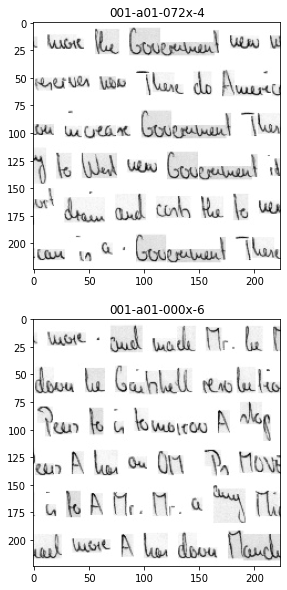

In [105]:
image_count_tr = len(list(training_data_dir.glob('*/*.jpg')))
print("Total number of patches in the training set:", image_count_tr)
print("Some patches from training set:")
display_rand_images(IAM_PATH+"/processed/001", R=2,C=1, size=(10,10))

Total number of patches in the validation set: 2739
Some patches from validation set:


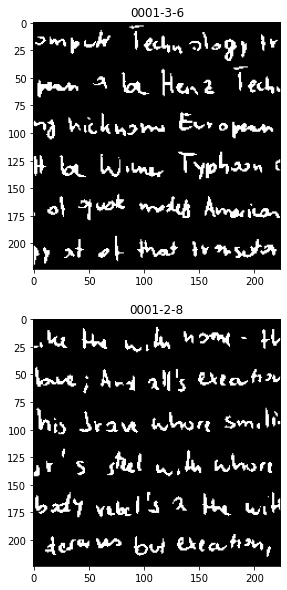

In [117]:
image_count_val = len(list(validation_data_dir.glob('*/*.jpg')))
print("Total number of patches in the validation set:", image_count_val)
print("Some patches from validation set:")
display_rand_images(CVL_PATH+"/trainset/processed/0001", R=2,C=1, size=(10,10))
# plt.imshow(mpimg.imread("/mounts/layout/dkvart/data/CVL/trainset/processed/0001/0001-1-1.jpg"))

In [9]:
batch_size=32
#load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_data_dir,
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23960 files belonging to 23 classes.


In [10]:
#load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_data_dir,
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3430 files belonging to 4 classes.


In [11]:
train_class_names = train_ds.class_names
print("Training set classes:")
print(train_class_names)

Training set classes:
['0001', '0002', '0003', '0004', '0005', '0006', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']


In [12]:
val_class_names = val_ds.class_names
print("Validation set classes:")
print(val_class_names)

Validation set classes:
['0041', '0042', '0047', '0050']


In [13]:
print("Sanity check")
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Sanity check
(32, 224, 224, 1)
(32,)


In [14]:
# tf documentation says this speeds the fetching from disk
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
output_dim = 128

In [16]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, (7, 7), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((3, 3)),
  layers.Dropout(0.5),
  layers.Conv2D(64, (5, 5), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((3, 3)),
  layers.Dropout(0.5),
  layers.Conv2D(96, (1, 1), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(output_dim, activation=None, kernel_regularizer=keras.regularizers.l2(l2=0.003)),
  layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 218, 218, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 64)        2

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tfa.losses.TripletSemiHardLoss())
logdir = os.path.join("/mounts/layout/dkvart/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[tensorboard_callback]
)

Epoch 1/100
  1/749 [..............................] - ETA: 0s - loss: 1.7528WARNING:tensorflow:From /mounts/layout/software/anaconda/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
749/749 [==============================] - 739s 986ms/step - loss: 1.5289 - val_loss: 1.3330
Epoch 2/100
749/749 [==============================] - 737s 984ms/step - loss: 1.1968 - val_loss: 0.9250
Epoch 3/100
749/749 [==============================] - 730s 975ms/step - loss: 0.9956 - val_loss: 1.0163
Epoch 4/100
749/749 [==============================] - 733s 979ms/step - loss: 0.8813 - val_loss: 0.8865
Epoch 5/100
749/749 [==============================] - 727s 971ms/step - loss: 0.8134 - val_loss: 1.0324
Epoch 6/100
749/749 [==============================] - 729s 973ms/step - loss: 0.7698 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



749/749 [==============================] - 728s 971ms/step - loss: 0.3067 - val_loss: 0.7196
Epoch 45/100
749/749 [==============================] - 725s 968ms/step - loss: 0.3022 - val_loss: 0.7641
Epoch 46/100
749/749 [==============================] - 724s 966ms/step - loss: 0.2996 - val_loss: 0.7224
Epoch 47/100
749/749 [==============================] - 726s 969ms/step - loss: 0.2949 - val_loss: 0.5538
Epoch 48/100
749/749 [==============================] - 727s 970ms/step - loss: 0.2929 - val_loss: 0.5648
Epoch 49/100
749/749 [==============================] - 726s 969ms/step - loss: 0.2847 - val_loss: 0.8181
Epoch 50/100
749/749 [==============================] - 723s 965ms/step - loss: 0.2871 - val_loss: 0.6921
Epoch 51/100
749/749 [==============================] - 725s 967ms/step - loss: 0.2824 - val_loss: 0.6954
Epoch 52/100
749/749 [==============================] - 727s 970ms/step - loss: 0.2783 - val_loss: 0.7020
Epoch 53/100
749/749 [==============================] - 725

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



749/749 [==============================] - 727s 970ms/step - loss: 0.2674 - val_loss: 0.7266
Epoch 56/100
749/749 [==============================] - 728s 972ms/step - loss: 0.2621 - val_loss: 0.5491
Epoch 57/100
749/749 [==============================] - 725s 968ms/step - loss: 0.2598 - val_loss: 0.6475
Epoch 58/100
749/749 [==============================] - 726s 970ms/step - loss: 0.2569 - val_loss: 0.8769
Epoch 59/100
749/749 [==============================] - 724s 966ms/step - loss: 0.2537 - val_loss: 0.7055
Epoch 60/100
749/749 [==============================] - 726s 969ms/step - loss: 0.2491 - val_loss: 0.6175
Epoch 61/100
749/749 [==============================] - 726s 969ms/step - loss: 0.2481 - val_loss: 0.7060
Epoch 62/100
749/749 [==============================] - 725s 969ms/step - loss: 0.2451 - val_loss: 0.7755
Epoch 63/100
749/749 [==============================] - 727s 970ms/step - loss: 0.2435 - val_loss: 0.5994
Epoch 64/100
749/749 [==============================] - 727

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



749/749 [==============================] - 728s 971ms/step - loss: 0.1976 - val_loss: 0.8075
Epoch 79/100
749/749 [==============================] - 726s 969ms/step - loss: 0.1947 - val_loss: 0.7342
Epoch 80/100
749/749 [==============================] - 728s 972ms/step - loss: 0.1934 - val_loss: 0.6080
Epoch 81/100
749/749 [==============================] - 727s 971ms/step - loss: 0.1888 - val_loss: 0.6745
Epoch 82/100
181/749 [======>.......................] - ETA: 8:59 - loss: 0.1807

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



749/749 [==============================] - 726s 970ms/step - loss: 0.1832 - val_loss: 0.5924
Epoch 86/100
749/749 [==============================] - 727s 970ms/step - loss: 0.1785 - val_loss: 0.8280
Epoch 87/100
749/749 [==============================] - 727s 970ms/step - loss: 0.1757 - val_loss: 0.6538
Epoch 88/100
749/749 [==============================] - 726s 969ms/step - loss: 0.1746 - val_loss: 0.5447
Epoch 89/100
513/749 [===================>..........] - ETA: 3:43 - loss: 0.1715

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



749/749 [==============================] - 726s 969ms/step - loss: 0.1650 - val_loss: 0.6004
Epoch 94/100
749/749 [==============================] - 726s 969ms/step - loss: 0.1616 - val_loss: 0.7537
Epoch 95/100
749/749 [==============================] - 724s 967ms/step - loss: 0.1626 - val_loss: 0.6759
Epoch 96/100
749/749 [==============================] - 725s 968ms/step - loss: 0.1592 - val_loss: 0.7903
Epoch 97/100
134/749 [====>.........................] - ETA: 9:39 - loss: 0.1487

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



749/749 [==============================] - 729s 973ms/step - loss: 0.1554 - val_loss: 0.6259


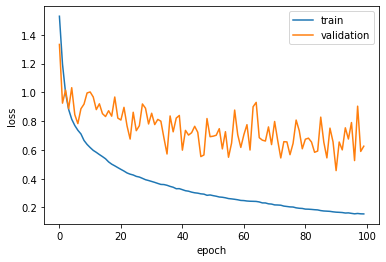

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [21]:
model.save('/mounts/layout/dkvart/models/'+exp)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /mounts/layout/dkvart/models/exp3/assets


# Produce vector representations

In [58]:
#load the best model
model = keras.models.load_model('/mounts/layout/dkvart/models/'+exp)

In [22]:
#load test dataset
test_data_dir = pathlib.Path(CVL_PATH+"/testset/processed")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  color_mode='grayscale',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20935 files belonging to 283 classes.


In [23]:
class_names = test_ds.class_names
print("Test set classes:")
print(class_names)

Test set classes:
['0052', '0053', '0057', '0058', '0059', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0083', '0084', '0095', '0096', '0097', '0098', '0152', '0153', '0155', '0156', '0157', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0182', '0183', '0184', '0185', '0186', '0187', '0188', '0189', '0190', '0191', '0192', '0193', '0194', '0195', '0196', '0197', '0198', '0199', '0200', '0201', '0202', '0203', '0204', '0205', '0206', '0207', '0208', '0209', '0210', '0211', '0212', '0213', '0214', '0215', '0216', '0217', '0218', '0219', '0220', '0221', '0222', '0223', '0224', '0227', '0228', '0229', '0230', '0231', '0232', '0233', '0234', '0235', '0236', '0237', '0238', '0239', '0240', '0241', '0242', '0243', '0244', '0245', '0246', '0247', '0248', '0249', '0250', '0251', '0252', '0254', '0255', '0256', '0262', '0263', '0265', '0285', '0286', '0287

In [25]:
def write_vecs_and_meta(dataset, model, OUT_meta, OUT_vecs):
    '''
    dataset --> tf.dataset that yields the batches of patches
    model --> a cnn that outputs vectors
    OUT_meta, OUT_vecs --> full paths to the output files for labels and vectors, respectively.
    I'm using this function to visualize vectors on projector.tensorflow.org
    '''
    out_m = io.open(OUT_meta, 'w', encoding='utf-8')
    out_v = open(OUT_vecs, 'a')
    for imgs, labels in dataset:
        imgs = imgs.numpy()
        labels = labels.numpy()
        predictions = model.predict(imgs)
        np.savetxt(out_v, predictions, delimiter='\t')
        [out_m.write(str(x) + "\n") for x in labels]
    out_m.close()
    out_v.close()
    
exp = 'exp3'
os.mkdir("/mounts/layout/dkvart/output_vecs/"+exp)
#vecs for training set  
write_vecs_and_meta(train_ds, model, "/mounts/layout/dkvart/output_vecs/"+exp+"/train_meta.tsv",
                    "/mounts/layout/dkvart/output_vecs/"+exp+"/train_vecs.tsv")
#vecs for validation set  
write_vecs_and_meta(val_ds, model, "/mounts/layout/dkvart/output_vecs/"+exp+"/val_meta.tsv",
                    "/mounts/layout/dkvart/output_vecs/"+exp+"/val_vecs.tsv")
#vecs for test set  
write_vecs_and_meta(test_ds, model, "/mounts/layout/dkvart/output_vecs/"+exp+"/test_meta.tsv",
                    "/mounts/layout/dkvart/output_vecs/"+exp+"//test_vecs.tsv")

# Building the Database for testset

Ideas: In order to be able to measure the accuracy of the model in a comparable (to the literature) way, we will combine the 256D vectors from the patches generated from the same sample into a single 256D vector, by taking the median of each component(across columns).

After that, I can build an entire database for the testset by organizing the vectors associated with each sample into the rows of a numpy matrix (also need y to store labels). I think I should also write these on the disk because there are a lot of experiments (soft criterion, hard criterion, for each K) I want to carry out. 

I can use my knn function, with a little modification to calculate the accuracy with soft/hard criterion.

In [26]:
def combine_vectors(filenames, model, output_dim):
    combined_matrix = np.empty((0,output_dim), dtype=np.float32)
    
    #I took parts of this code from the documentation of image_dataset_from_directory
    #cv2 reads images in a different way, so I need to be careful about that
    for file in filenames:
        img = io_ops.read_file(str(file))
        img = image_ops.decode_image(img, channels=1, expand_animations=False)#read in grayscale
        img = image_ops.resize_images_v2(img, (img_height, img_width), method='bilinear')
        img.set_shape((img_height, img_width, 1))
        img = img.numpy()[np.newaxis, :]
        prediction = model.predict(img)
        combined_matrix = np.append(combined_matrix, prediction, axis=0)
    return np.median(combined_matrix, axis=0)[np.newaxis,:]


def build_database(PATH, model, output_dim):
    directory = pathlib.Path(PATH)
    DATABASE_X = np.empty((0,output_dim), dtype=np.float32)
    DATABASE_Y = []
    for folder in directory.glob('*'):
        writer_id = folder.stem
        dct = read_and_organize_filenames(str(folder), file_extension='.jpg')
        
        for sample_id, filenames in dct.items():
            vector = combine_vectors(filenames, model, output_dim)
            DATABASE_Y.append(writer_id)
            DATABASE_X = np.append(DATABASE_X, vector, axis=0)
            
    DATABASE_Y = np.array(DATABASE_Y)
    return DATABASE_X, DATABASE_Y
    
DATABASE_X, DATABASE_Y = build_database(CVL_PATH+"/testset/processed/", model, output_dim)
print(DATABASE_X.shape)
print(DATABASE_Y.shape)

(1409, 128)
(1409,)


In [27]:
def write_to_disk(DATABASE_X, DATABASE_Y, OUT_X, OUT_Y):
    np.savetxt(OUT_X, DATABASE_X, delimiter='\t')
    np.savetxt(OUT_Y, DATABASE_Y, fmt="%s")

In [28]:
write_to_disk(DATABASE_X, DATABASE_Y, "/mounts/layout/dkvart/output_vecs/"+exp+"/db_vecs.tsv",
              "/mounts/layout/dkvart/output_vecs/"+exp+"/db_meta.tsv" )

In [211]:
def load_database(vecs_PATH, meta_PATH):
    database_X = np.loadtxt(open(vecs_PATH, "r"), delimiter='\t')
    database_Y = np.loadtxt(open(meta_PATH, "r"), dtype=np.string_)
    return database_X, database_Y
DATABASE_X, DATABASE_Y = load_database("/mounts/layout/dkvart/output_vecs/db_vecs.tsv",
                                       "/mounts/layout/dkvart/output_vecs/db_meta.tsv")

# Evaluation of the model

In [29]:
#calculate the euclidean distance of example with respect to all rows in data
def distance(example, data):
    return np.sqrt(np.sum((data-example)**2, axis=1))

def K_closest(K, data, labels, example):
    #calculate distances
    distances = distance(example, data)
    #sort the array and get corresponding indexes
    sorted_indexes = distances.argsort()
    #return the labels of K closest neighbours
    return labels[sorted_indexes[:K]]

In [30]:
def evaluate(db_X, db_Y, K, criterion):
    num_correct = 0
    num_examples = db_X.shape[0]
    for i in range(num_examples):
        K_nearest_neighbors = K_closest(K, np.delete(db_X, (i), axis=0),#remove i-th row from X, Y
                                        np.delete(db_Y,(i)), db_X[i])
        actual_label = db_Y[i]
        if(criterion=='soft'):
            if actual_label in K_nearest_neighbors:
                num_correct += 1
        elif(criterion=='hard'):
            if np.all(K_nearest_neighbors==actual_label):
                num_correct += 1
    return num_correct/num_examples


In [31]:
top_1_soft = evaluate(DATABASE_X, DATABASE_Y, 1, 'soft')
top_5_soft = evaluate(DATABASE_X, DATABASE_Y, 5, 'soft')
top_10_soft = evaluate(DATABASE_X, DATABASE_Y, 10, 'soft')

top_1_hard = evaluate(DATABASE_X, DATABASE_Y, 1, 'hard')
top_2_hard = evaluate(DATABASE_X, DATABASE_Y, 2, 'hard')
top_3_hard = evaluate(DATABASE_X, DATABASE_Y, 3, 'hard')
top_4_hard = evaluate(DATABASE_X, DATABASE_Y, 4, 'hard')

In [32]:
print("Soft evaluation")
print("Top-1:", round(top_1_soft,2))
print("Top-5:", round(top_5_soft,2))
print("Top-10:", round(top_10_soft,2))

Soft evaluation
Top-1: 0.82
Top-5: 0.92
Top-10: 0.96


In [33]:
print("Hard evaluation")
print("Top-1:", round(top_1_hard,2))
print("Top-2:", round(top_2_hard,2))
print("Top-3:", round(top_3_hard,2))
print("Top-4:", round(top_4_hard,2))

Hard evaluation
Top-1: 0.82
Top-2: 0.68
Top-3: 0.48
Top-4: 0.28
